In [9]:
# Import all the necessary packages
import uproot  # check out the documentation about the basics at https://uproot.readthedocs.io/en/latest/basic.html
import os
import glob
import matplotlib.pyplot as plt
import awkward as ak
import datetime as dt
import vector

In [10]:
DATA_DIR = "/home/siimep_x11/Documents/Magister/Particle"
PATHS = list(set(glob.glob(os.path.join(DATA_DIR, '*.root'))))

In [11]:
# For the purposes of this lesson, let us open only the first of the MC files.
infile = [s for s in PATHS if 'ZZTo2e2mu' in s][0]
events = uproot.open(infile + ":Events") # Take the events directory of the .root file

# In order to just browse the contents of the events like datatypes and branch names:
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
PV_npvs              | int32_t                  | AsDtype('>i4')
PV_x                 | float                    | AsDtype('>f4')
PV_y                 | float                    | AsDtype('>f4')
PV_z                 | float                    | AsDtype('>f4')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge       

In [12]:
# As the files are large it is unlikely we'll be able to read them fully into memory
# for example:
nEvents = events.num_entries
eventsPerMB = events.num_entries_for("1 MB")
print ("Total MB needed: %.1f" % (nEvents/eventsPerMB))
print ("Total number of events: %d" % nEvents)

Total MB needed: 173.2
Total number of events: 1497445


In [13]:
# So if we want to process those events we should iterate over them
# However it's reasonable to read the events in in batches to make processing them faster
batch_size = 5000

# Let's create two vectors for later plotting
muonPt = []
numMuons = []
ePt = []
numE = []

nev = 0
start=dt.datetime.now()
for batch in events.iterate(step_size=batch_size):
    print("Starting events %d until %d" % (nev,nev+batch_size))
    nev+=batch_size
    # Let's convert the batch of events to an awkward array
    for ev in batch:
        numMuons.append(ev['nMuon'])
        muonPt+=ev['Muon_pt'].to_list()
        numE.append(ev['nElectron'])
        ePt+=ev['Electron_pt'].to_list()

    # Let's only look the first ca 100k events
    if nev >= 100000: break
stop=dt.datetime.now()
print(stop-start)

Starting events 0 until 5000
Starting events 5000 until 10000
Starting events 10000 until 15000
Starting events 15000 until 20000
Starting events 20000 until 25000
Starting events 25000 until 30000
Starting events 30000 until 35000
Starting events 35000 until 40000
Starting events 40000 until 45000
Starting events 45000 until 50000
Starting events 50000 until 55000
Starting events 55000 until 60000
Starting events 60000 until 65000
Starting events 65000 until 70000
Starting events 70000 until 75000
Starting events 75000 until 80000
Starting events 80000 until 85000
Starting events 85000 until 90000
Starting events 90000 until 95000
Starting events 95000 until 100000
0:00:22.978814


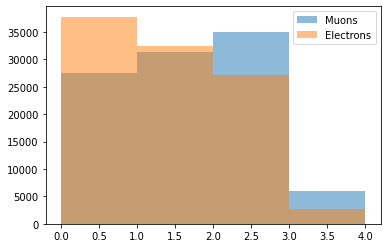

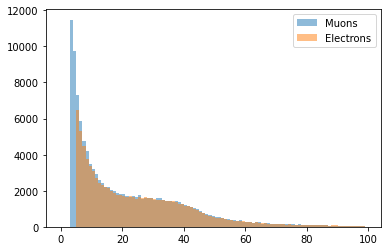

In [14]:
# Let's now plot those two distributions
plt.hist(numMuons,bins=range(5),alpha=0.5,label='Muons')
plt.hist(numE,bins=range(5),alpha=0.5,label='Electrons')
plt.legend()
plt.show()
plt.hist(muonPt,bins=range(100),alpha=0.5,label='Muons')
plt.hist(ePt,bins=range(100),alpha=0.5,label='Electrons')
plt.legend()
plt.show()

In [15]:
# As you saw it takes quite a time to process even just 100k events. The datasets however contains 126M events...
# So first off let's do some optimization:
#   We don't need to read all variables if we don't plan to use them
#   We can also filter by some criteria, for example if we are looking for only events with at least 2 muons
batch_size = 5000

# Let's create two vectors for later plotting
muonPt = []
numMuons = []
ePt = []
numE = []
nev = 0
start=dt.datetime.now()


for batch in events.iterate(step_size=batch_size,
                            expressions=["nMuon","Muon_pt","nElectron","Electron_pt"],
                            cut="nMuon+nElectron>3"):
    print("Starting events %d until %d" % (nev,nev+batch_size))
    nev+=batch_size
    # Let's convert the batch of events to an awkward array
    for ev in batch:
        numMuons.append(ev['nMuon'])
        muonPt+=ev['Muon_pt'].to_list()
        numE.append(ev['nElectron'])
        ePt+=ev['Electron_pt'].to_list()

    # Let's only look the first ca 50k events
    if nev >= 100000: break
        
stop=dt.datetime.now()
print(stop-start)

Starting events 0 until 5000
Starting events 5000 until 10000
Starting events 10000 until 15000
Starting events 15000 until 20000
Starting events 20000 until 25000
Starting events 25000 until 30000
Starting events 30000 until 35000
Starting events 35000 until 40000
Starting events 40000 until 45000
Starting events 45000 until 50000
Starting events 50000 until 55000
Starting events 55000 until 60000
Starting events 60000 until 65000
Starting events 65000 until 70000
Starting events 70000 until 75000
Starting events 75000 until 80000
Starting events 80000 until 85000
Starting events 85000 until 90000
Starting events 90000 until 95000
Starting events 95000 until 100000
0:00:05.977612


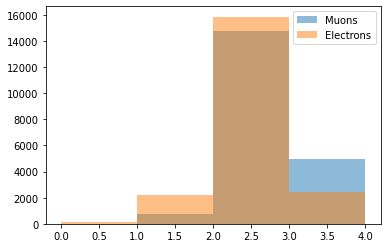

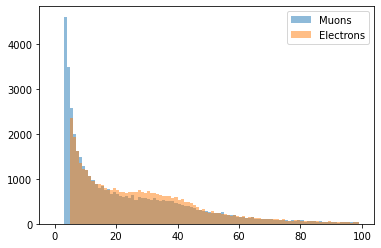

In [16]:
# Let's now plot those two distributions
plt.hist(numMuons,bins=range(5),alpha=0.5,label='Muons')
plt.hist(numE,bins=range(5),alpha=0.5,label='Electrons')
plt.legend()
plt.show()
plt.hist(muonPt,bins=range(100),alpha=0.5,label='Muons')
plt.hist(ePt,bins=range(100),alpha=0.5,label='Electrons')
plt.legend()
plt.show()

In [17]:
filtered = events.arrays(None,"(nMuon+nElectron>3)")
print("Filtered set size: %d / %d" % (len(filtered),events.num_entries))

Filtered set size: 307545 / 1497445


In [19]:
# You can save a filtered array to a file for later usage and faster/slimmer dataset
ak.to_parquet(filtered,'skim.parquet')

# You can also read it from said file (in a different notebook for example)
dataset = ak.from_parquet('skim.parquet')

ModuleNotFoundError: to use ak.to_parquet, you must install pyarrow:

    pip install pyarrow

or

    conda install -c conda-forge pyarrow


# Individual work

Your task now is to find how to reduce the datasets further without limiting too much the samples in advance
and then trimming the samples smaller. Goal is to reduce the dataset enough that you can run through events to parse them and compute output values